# Exploration of Retinal Cells with AngioTool

## Retinal angiogenesis

**We are interested in the possible effects of DEE on blood vessel formation (angiogenesis).**

We consider post-natal day 3 ("P3") retinal cells from mice; some have mutant genes while others are normal.

At this age, the blood vessels are on a single plane (superficial layer) which means we don't need to worry about complicating 3D effects. 


GSL I-B4 isolectin was used as a marker for endothelial cells. 

## AngioTool's processing chain

- [Multi-scale second order local structure (Hessian)](http://www.tecn.upf.es/~afrangi/articles/miccai1998.pdf)
    - Second order derivatives through convolutions with derivatives of Gaussians
        - Computationally favorable
        - Introduces a scale factor that matches vessel size
    - Map the eigenvectors of the Hessian onto an ellipsoid where the axis' semi-lengths are magnitudes of respective eigenvalues
        - Magnitudes of eigenvalues describe structure
        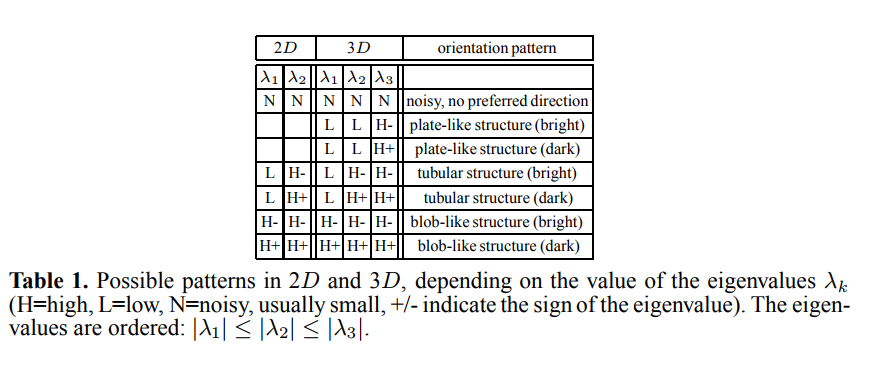
- [Convex Hull](http://scikit-image.org/docs/dev/auto_examples/edges/plot_convex_hull.html#sphx-glr-auto-examples-edges-plot-convex-hull-py)
    - Given a binary image, the convex hull is the set of pixels contained within the smallest convex polygon that will surround all of the foreground pixels.
    - Used for calculating area
- [Skeletonization](http://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html#sphx-glr-auto-examples-edges-plot-skeleton-py)
    - Given a binary image, skeletonization yields a frame which is 1 pixel-wide.
    - Used for calculating vessel lengths

AngioTool outputs values such as 

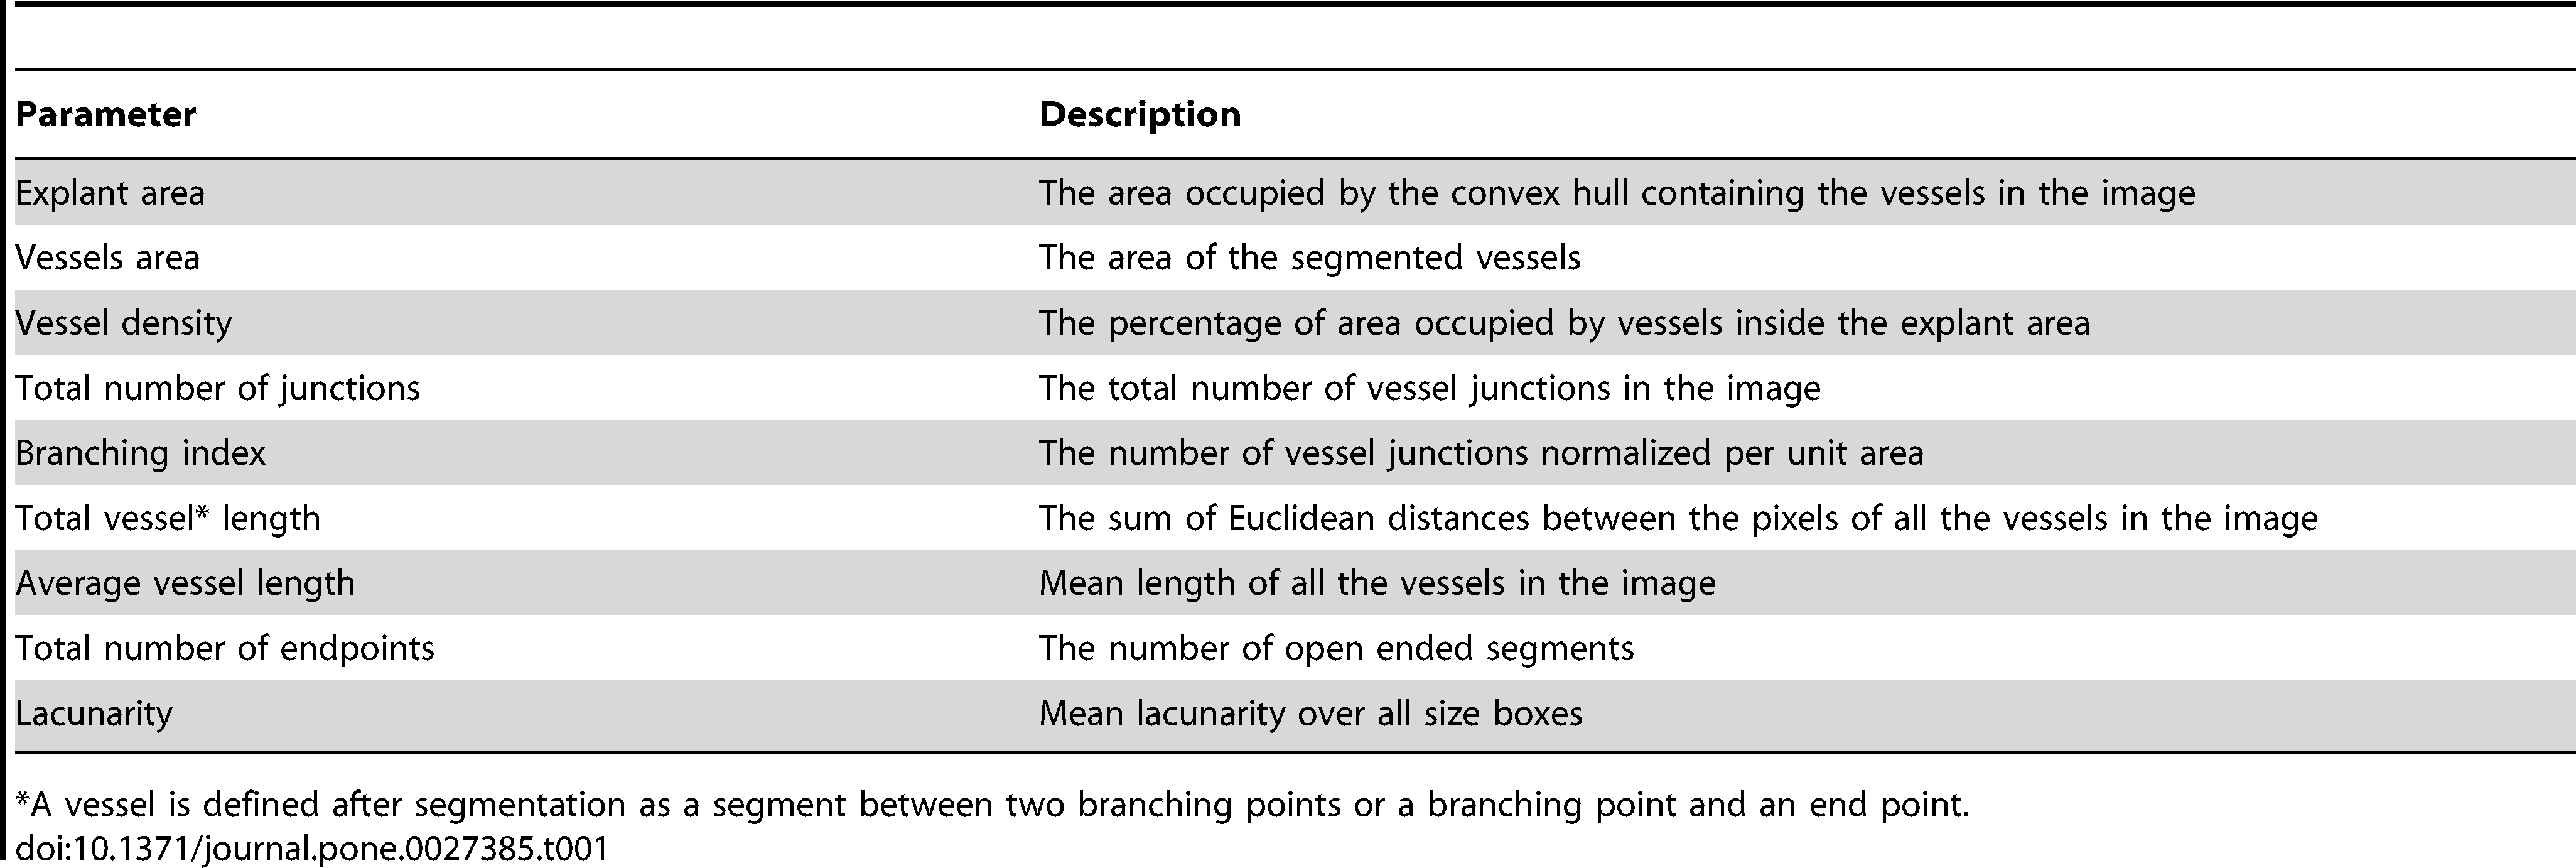

After using [AngioTool 0.6a](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3217985/) with varied parameters

| Low Threshold 	| High Threshold 	| Small Particle Size 	| Fill Holes 	|
|---------------	|----------------	|---------------------	|------------	|
| 0             	| 255            	| ?               	    | ?        	|


We obtain images such as 

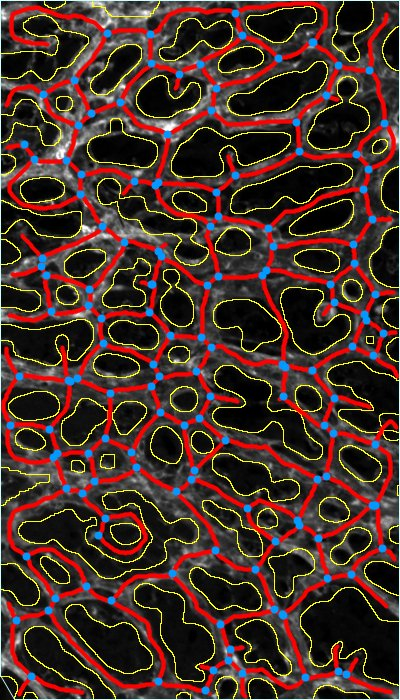

where the features are

| Blue dots       | Red lines       | Yellow outlines  |
| --------------- |:---------------:| ----------------:|
| Vessel junction | Vessel skeleton | Vessel area      |



and the AngioTool results are saved in an Excel file.

### Load data
We need to combine the genotype info with the AngioTool data so that we can do actual analysis.


Start by loading the Excel spreadsheet with select columns (we don't care about the date, time, etc.) into a pandas Dataframe. 

In [1]:
import numpy as np
import pandas as pd

data = pd.read_excel('./processed/tweaked/TweakedResults11-6-2017.xls',
                    usecols = "A, G, N, O, Q, S")
## These are the columns from Excel that we're interested in.

Confirm you loaded the correct thing by looking at the header. You can always look at a Dataframe's header through `df.head()`

In [2]:
data.head()

,Image Name,Vessel Thickness,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
0,35-3b-field 1.tif,9,65.034498,119,14.215480,16
1,35-3b-field 2.tif,9,61.498248,183,16.877167,17
2,35-3b-field 3.tif,9,55.247350,157,15.500902,29
3,35-5b-field 1.tif,10,55.218967,138,14.465886,37
4,35-5-field 2.tif,9,51.731472,134,13.181119,32


### Create unique IDs for each animal
We need to parse the Image Name column in order to get a unique ID for each animal. The unique ID will be used for pairing genotypes using the Genotyping Key document.

I'm using list comprehensions to get Litter/ID info from the Image Name. Both are added to our `data` DataFrame.

In [3]:
data['Litter'] = [x[:2] for x in data['Image Name']]
data['AnimalID'] = [x[:4] for x in data['Image Name']]
data.head()

,Image Name,Vessel Thickness,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points,Litter,AnimalID
0,35-3b-field 1.tif,9,65.034498,119,14.215480,16,35,35-3
1,35-3b-field 2.tif,9,61.498248,183,16.877167,17,35,35-3
2,35-3b-field 3.tif,9,55.247350,157,15.500902,29,35,35-3
3,35-5b-field 1.tif,10,55.218967,138,14.465886,37,35,35-5
4,35-5-field 2.tif,9,51.731472,134,13.181119,32,35,35-5


### Load genotyping key
Once again, we'll use the `read_excel` tool found within the `pandas` library.

In [4]:
key = pd.read_excel('genotypingkey.xlsx')
key

,Litter,ID,AnimalID,Genotype
0,35,3,35-3,+/+
1,35,5,35-5,DEE/DEE
2,35,6,35-6,DEE/DEE
3,35,7,35-7,DEE/+
4,36,2,36-2,DEE/+
5,36,3,36-3,+/+
6,36,4,36-4,DEE/DEE
7,36,5,36-5,+/+
8,36,6,36-6,DEE/+
9,37,3,37-3,DEE/+


### Combine the dataframes
We'll merge the two dataframes by using the `merge` function from the `pandas` library. Notice how `AnimalID` is used to match.

We can also drop unneeded columns such as `Image Name`, `ID`, and the duplicated `Litter_y`.

In [5]:
merged_inner = pd.merge(left = data, right = key, how = 'inner',
                        left_on = 'AnimalID', right_on = 'AnimalID')

merged_inner.drop('Litter_y', axis = 1, inplace = True)
merged_inner.drop('ID', axis = 1, inplace = True)

In [6]:
merged_inner.rename(columns = {'Litter_x':'Litter'},inplace=True)
merged_inner.drop('Image Name', axis = 1, inplace = True)
merged_inner

,Vessel Thickness,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points,Litter,AnimalID,Genotype
0,9,65.034498,119,14.215480,16,35,35-3,+/+
1,9,61.498248,183,16.877167,17,35,35-3,+/+
2,9,55.247350,157,15.500902,29,35,35-3,+/+
3,10,55.218967,138,14.465886,37,35,35-5,DEE/DEE
4,9,51.731472,134,13.181119,32,35,35-5,DEE/DEE
5,9,53.907283,125,13.055196,47,35,35-5,DEE/DEE
6,10,62.635569,148,15.047376,38,36,36-4,DEE/DEE
7,10,65.269094,169,16.007724,27,36,36-4,DEE/DEE
8,13,60.138528,113,13.177062,28,36,36-4,DEE/DEE
9,15,62.868619,87,11.536940,27,36,36-4,DEE/DEE


### Average over AnimalID and Genotype
Now that we have unblinded our data by assigning genotypes to the various animals, let's pivot by `Genotype` and `AnimalID`.
We can also get the mean values for each animal.

In [7]:
pivoteddata = merged_inner.set_index(['Genotype', 'Litter'])
data_mean = pivoteddata.mean(level=['Genotype', 'Litter'])
data_mean

Vessel Thickness  Vessels percentage area  \
Genotype Litter                                              
+/+      35              9.000000                60.593365   
DEE/DEE  35              9.333333                53.619241   
         36             11.333333                62.152266   
+/+      36             10.333333                64.298531   
DEE/+    37             10.000000                61.730806   
DEE/DEE  37             11.000000                54.291983   
+/+      37             11.666667                58.682159   

                 Total Number of Junctions  Total Vessels Length  \
Genotype Litter                                                    
+/+      35                     153.000000             15.531183   
DEE/DEE  35                     132.333333             13.567400   
         36                     136.833333             14.415517   
+/+      36                     171.666667             16.085692   
DEE/+    37                     161.000000             15.673020   
DEE/DEE  37                      98.333333             12.666500   
+/+      37                     110.000000             13.102471   

                 Total Number of End Points  
Genotype Litter                              
+/+      35                       20.666667  
DEE/DEE  35                       38.666667  
         36                       31.166667  
+/+      36                       26.333333  
DEE/+    37                       32.500000  
DEE/DEE  37                       27.666667  
+/+      37                       25.333333

###### In case you missed it, it only took two lines to go from `merged_inner` to `data_mean`!!

### Split data
Let's separate our data by
- +/+ wild type 
- DEE/DEE mutant
- DEE/+ heterozygous 

In [8]:
wild = data_mean.query('Genotype == "+/+"')
wild

Vessel Thickness  Vessels percentage area  \
Genotype Litter                                              
+/+      35              9.000000                60.593365   
         36             10.333333                64.298531   
         37             11.666667                58.682159   

                 Total Number of Junctions  Total Vessels Length  \
Genotype Litter                                                    
+/+      35                     153.000000             15.531183   
         36                     171.666667             16.085692   
         37                     110.000000             13.102471   

                 Total Number of End Points  
Genotype Litter                              
+/+      35                       20.666667  
         36                       26.333333  
         37                       25.333333

In [9]:
mutant = data_mean.query('Genotype == "DEE/DEE"')
mutant

Vessel Thickness  Vessels percentage area  \
Genotype Litter                                              
DEE/DEE  35              9.333333                53.619241   
         36             11.333333                62.152266   
         37             11.000000                54.291983   

                 Total Number of Junctions  Total Vessels Length  \
Genotype Litter                                                    
DEE/DEE  35                     132.333333             13.567400   
         36                     136.833333             14.415517   
         37                      98.333333             12.666500   

                 Total Number of End Points  
Genotype Litter                              
DEE/DEE  35                       38.666667  
         36                       31.166667  
         37                       27.666667

In [10]:
het = data_mean.query('Genotype == "DEE/+"')
het

,,Vessel Thickness,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
Genotype,Litter,,,,,
DEE/+,37,10.0,61.730806,161.0,15.67302,32.5


In [11]:
## Get data arrays
wildVPA = wild['Vessels percentage area'].values
wildNJunctions = wild['Total Number of Junctions'].values
wildVesselsLength = wild['Total Vessels Length'].values
wildNEndPoints = wild['Total Number of End Points'].values

mutantVPA = mutant['Vessels percentage area'].values
mutantNJunctions = mutant['Total Number of Junctions'].values
mutantVesselsLength = mutant['Total Vessels Length'].values
mutantNEndPoints = mutant['Total Number of End Points'].values

## Hypothesis testing

Now that we have our data in an easily indexible form, we can do a **paired t-test**.

`scipy` contains useful things for scientific analysis, and they have a built-in paired t-test function called `ttest_rel`.

In [12]:
from scipy import stats

print('VPA: ', stats.ttest_rel(wildVPA, mutantVPA))
print('N Junctions: ',stats.ttest_rel(wildNJunctions, mutantNJunctions))
print('Vessels Length: ',stats.ttest_rel(wildVesselsLength, mutantVesselsLength))
print('N End Points: ',stats.ttest_rel(wildNEndPoints, mutantNEndPoints))

VPA:  Ttest_relResult(statistic=3.2287141640509156, pvalue=0.084014759795731003)
N Junctions:  Ttest_relResult(statistic=3.3203887320440595, pvalue=0.079973415493386574)
Vessels Length:  Ttest_relResult(statistic=2.8983540691676981, pvalue=0.10127827164808764)
N End Points:  Ttest_relResult(statistic=-1.7263062636468711, pvalue=0.22643402019041875)


### Exploratory plots

QQ plots, etc. to follow after we have more than three data points per plot.


In [13]:
#from scipy import stats
#fig, ax = plt.subplots(2, 4, figsize=(10,10))

#stats.probplot(wildVPA, dist='norm', plot=plt)
#plt.show()

## Boxplots for different parameters

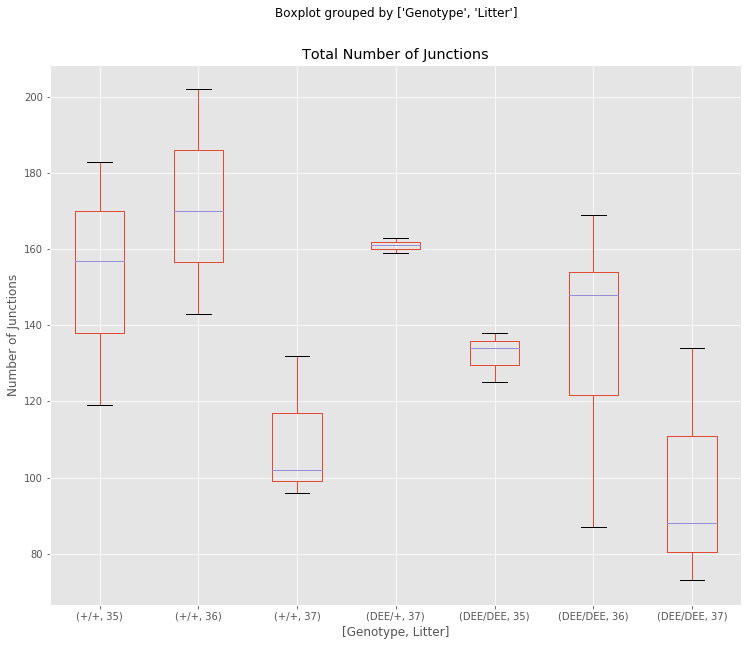

In [14]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

merged_inner.boxplot(column = ['Total Number of Junctions'],
                     by = ['Genotype', 'Litter'],
                     figsize = (12,10)
                    )
plt.ylabel('Number of Junctions')
plt.show()

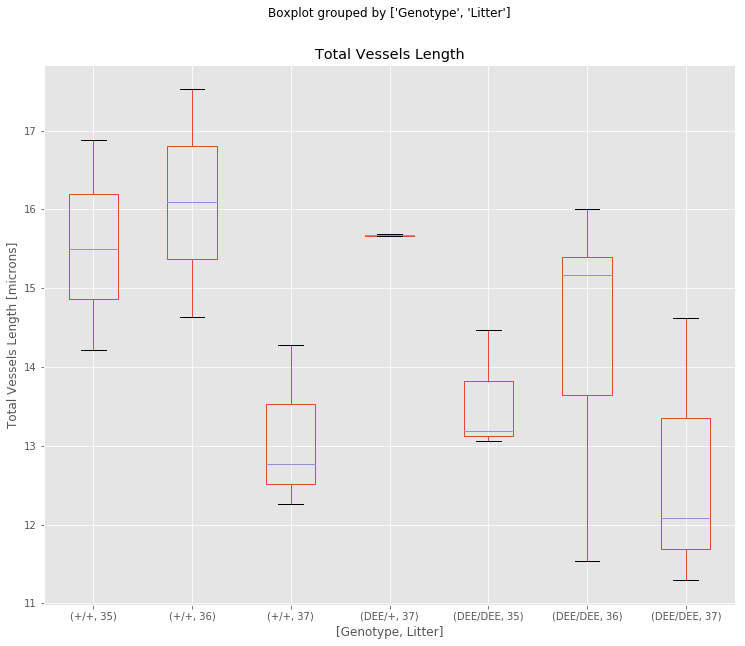

In [15]:
merged_inner.boxplot(column = ['Total Vessels Length'],
                     by = ['Genotype', 'Litter'],
                     figsize = (12,10)
                    )
plt.ylabel('Total Vessels Length [microns]')
plt.show()

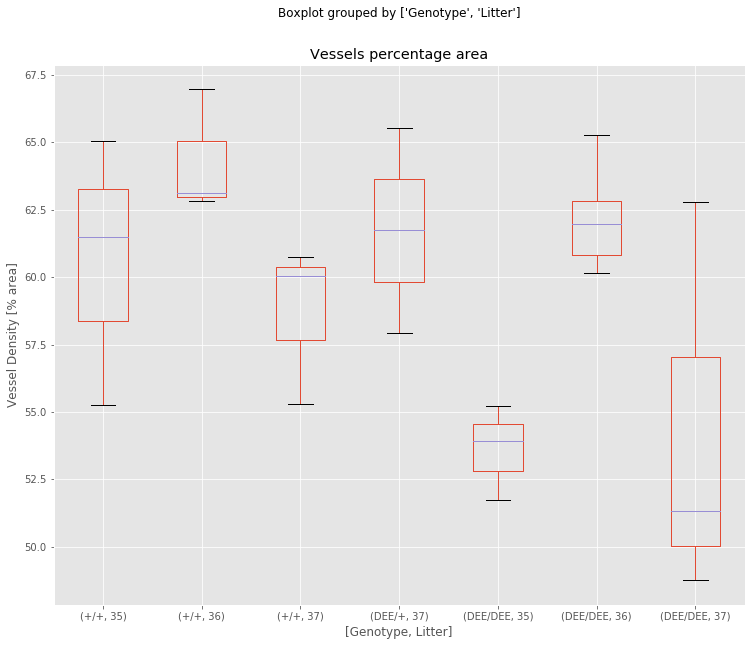

In [16]:
merged_inner.boxplot(column = ['Vessels percentage area'],
                     by = ['Genotype', 'Litter'],
                     figsize = (12,10)
                    )
plt.ylabel('Vessel Density [% area]')
plt.show()

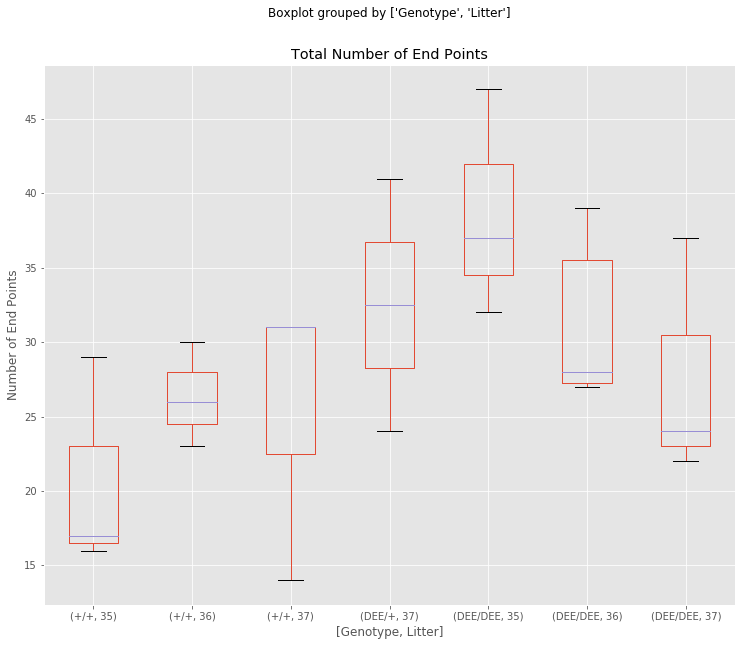

In [17]:
merged_inner.boxplot(column = ['Total Number of End Points'],
                     by = ['Genotype', 'Litter'],
                     figsize = (12,10)
                    )
plt.ylabel('Number of End Points')
plt.show()

If you want to look at the numbers after averaging, here they are.

In [18]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Number of End Points']
                     .describe()
)

count       mean        std   min    25%   50%    75%   max
Litter Genotype                                                             
35     +/+         3.0  20.666667   7.234178  16.0  16.50  17.0  23.00  29.0
       DEE/DEE     3.0  38.666667   7.637626  32.0  34.50  37.0  42.00  47.0
36     +/+         3.0  26.333333   3.511885  23.0  24.50  26.0  28.00  30.0
       DEE/DEE     6.0  31.166667   5.706721  27.0  27.25  28.0  35.50  39.0
37     +/+         3.0  25.333333   9.814955  14.0  22.50  31.0  31.00  31.0
       DEE/+       2.0  32.500000  12.020815  24.0  28.25  32.5  36.75  41.0
       DEE/DEE     3.0  27.666667   8.144528  22.0  23.00  24.0  30.50  37.0

In [19]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Vessels percentage area']
                     .describe()
)

count       mean       std        min        25%        50%  \
Litter Genotype                                                                
35     +/+         3.0  60.593365  4.955923  55.247350  58.372799  61.498248   
       DEE/DEE     3.0  53.619241  1.761499  51.731472  52.819378  53.907283   
36     +/+         3.0  64.298531  2.311205  62.807058  62.967370  63.127682   
       DEE/DEE     6.0  62.152266  1.864851  60.138528  60.834866  61.984257   
37     +/+         3.0  58.682159  2.958607  55.290481  57.656938  60.023394   
       DEE/+       2.0  61.730806  5.383032  57.924427  59.827617  61.730806   
       DEE/DEE     3.0  54.291983  7.470105  48.762370  50.042961  51.323552   

                       75%        max  
Litter Genotype                        
35     +/+       63.266373  65.034498  
       DEE/DEE   54.563125  55.218967  
36     +/+       65.044268  66.960854  
       DEE/DEE   62.810357  65.269094  
37     +/+       60.377998  60.732602  
       DEE/+     63.633995  65.537184  
       DEE/DEE   57.056789  62.790027

In [20]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Number of Junctions']
                     .describe()
)

count        mean        std    min     25%    50%    75%  \
Litter Genotype                                                              
35     +/+         3.0  153.000000  32.186954  119.0  138.00  157.0  170.0   
       DEE/DEE     3.0  132.333333   6.658328  125.0  129.50  134.0  136.0   
36     +/+         3.0  171.666667  29.535290  143.0  156.50  170.0  186.0   
       DEE/DEE     6.0  136.833333  30.668659   87.0  121.75  148.0  154.0   
37     +/+         3.0  110.000000  19.287302   96.0   99.00  102.0  117.0   
       DEE/+       2.0  161.000000   2.828427  159.0  160.00  161.0  162.0   
       DEE/DEE     3.0   98.333333  31.785741   73.0   80.50   88.0  111.0   

                   max  
Litter Genotype         
35     +/+       183.0  
       DEE/DEE   138.0  
36     +/+       202.0  
       DEE/DEE   169.0  
37     +/+       132.0  
       DEE/+     163.0  
       DEE/DEE   134.0

In [21]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Vessels Length']
                     .describe()
)

count       mean       std        min        25%        50%  \
Litter Genotype                                                                
35     +/+         3.0  15.531183  1.331102  14.215480  14.858191  15.500902   
       DEE/DEE     3.0  13.567400  0.780655  13.055196  13.118157  13.181119   
36     +/+         3.0  16.085692  1.441889  14.639636  15.366850  16.094064   
       DEE/DEE     6.0  14.415517  1.706224  11.536940  13.644641  15.169351   
37     +/+         3.0  13.102471  1.049104  12.258290  12.515215  12.772140   
       DEE/+       2.0  15.673020  0.020813  15.658303  15.665662  15.673020   
       DEE/DEE     3.0  12.666500  1.740829  11.292903  11.687607  12.082311   

                       75%        max  
Litter Genotype                        
35     +/+       16.189034  16.877167  
       DEE/DEE   13.823503  14.465886  
36     +/+       16.808720  17.523376  
       DEE/DEE   15.397337  16.007724  
37     +/+       13.524562  14.276983  
       DEE/+     15.680379  15.687737  
       DEE/DEE   13.353298  14.624286

### Potentially useful snippets for the future

In [22]:
idx = pd.IndexSlice
data_mean.index

MultiIndex(levels=[['+/+', 'DEE/+', 'DEE/DEE'], ['35', '36', '37']],
           labels=[[0, 2, 2, 0, 1, 2, 0], [0, 0, 1, 1, 2, 2, 2]],
           names=['Genotype', 'Litter'])

In [23]:
# equivalent to data_mean.query('Genotype == "+/+"')
#data_mean.loc[idx[:,'+/+'],:]  

In [24]:
diffdata = ((mutant - wild.values)
            .rename(
                columns={
                    'Vessels percentage area':'diff Vessels percentage area',
                    'Total Number of Junctions':'diff Number of Junctions',
                    'Total Vessels Length':'diff Vessels Length',
                    'Total Number of End Points':'diff Number of End Point'}
                    )
            )

diffdata.drop('Genotype', axis=0, level=1, inplace=True)
diffdata

Vessel Thickness  diff Vessels percentage area  \
Genotype Litter                                                   
DEE/DEE  35              0.333333                     -6.974125   
         36              1.000000                     -2.146266   
         37             -0.666667                     -4.390176   

                 diff Number of Junctions  diff Vessels Length  \
Genotype Litter                                                  
DEE/DEE  35                    -20.666667            -1.963782   
         36                    -34.833333            -1.670175   
         37                    -11.666667            -0.435971   

                 diff Number of End Point  
Genotype Litter                            
DEE/DEE  35                     18.000000  
         36                      4.833333  
         37                      2.333333